In [ ]:
 ! pip install -q kaggle

In [ ]:
 from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ronggurmwp","key":"659addeda6fe20f4cdbb154d65d80c1b"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c praktikum-2-rnn-if4074-2023

  0% 0.00/5.21k [00:00<?, ?B/s]
100% 5.21k/5.21k [00:00<00:00, 16.7MB/s]


In [ ]:
!unzip praktikum-2-rnn-if4074-2023.zip

Archive:  praktikum-2-rnn-if4074-2023.zip
  inflating: test_LTC.csv            
  inflating: train_LTC.csv           


In [ ]:
import tensorflow as tf

In [ ]:
import pandas as pd

# data di preprocess menggunakan excel
df_train = pd.read_csv('train_LTC.csv', delimiter=',')
df_test = pd.read_csv('test_LTC.csv', delimiter=',')

In [ ]:
df_train.head(20)

,Date,Open,High,Low,Close
0,2018-01-12,31.88,34.99,31.00,34.22
1,2018-02-12,34.22,34.82,32.81,33.20
2,2018-03-12,33.20,33.20,29.62,30.53
3,2018-04-12,30.53,31.88,29.66,30.77
4,2018-05-12,30.77,31.06,28.67,28.70
5,2018-06-12,28.70,30.09,25.80,26.22
6,2018-07-12,26.22,26.55,22.17,24.96
7,2018-08-12,24.96,25.74,22.94,24.00
8,2018-09-12,24.00,26.60,24.00,25.23
9,2018-10-12,25.23,25.66,23.62,24.12


In [ ]:
df_test.head()

,Date
0,2019-11-27
1,2019-11-28
2,2019-11-29
3,2019-11-30
4,2019-12-01


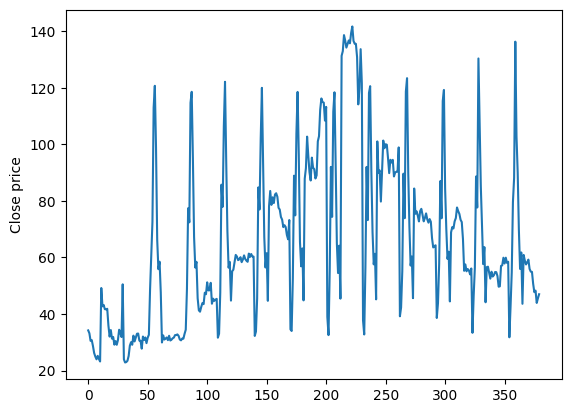

In [ ]:
# plt.figure(figsize=(15,5))
plt.plot(df_train['Close'])
plt.ylabel('Close price')
plt.show()

In [ ]:
len(df_train)

380

In [ ]:
df_train.info()

In [ ]:
len(df_test)

168

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    168 non-null    object
dtypes: object(1)
memory usage: 1.4+ KB


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt


In [ ]:
scaler = MinMaxScaler()
df_train_scaled = scaler.fit_transform(df_train[['Open', 'Close', 'High', 'Low']])
# scaled_data = scaler.fit_transform(df_test[['Open', 'Close', 'High', 'Low']])

In [ ]:
# df_train_scaled.head()

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    print(len(data) - seq_length)
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


In [ ]:
seq_length = 3  # You can adjust the sequence length
X_train, y_train = create_sequences(df_train_scaled, seq_length)
# X_test, y_test = create_sequences(df_train_scaled, seq_length)

# seq_length_variations = [3, 5 , 7, 10, 15, 25, 40]
seq_length_variations = [1,2,3, 5, 10, 15, 25]

377


In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
def custom_accuracy(y_true, y_pred, admitted_range=0.1):
    lower_bound = y_true - admitted_range
    upper_bound = y_true + admitted_range

    is_within_range = tf.math.logical_and(y_pred >= lower_bound, y_pred <= upper_bound)
    accuracy = tf.reduce_mean(tf.cast(is_within_range, tf.float32))

    return accuracy

In [ ]:
# Custom callback to print the last epoch
class PrintLastEpoch(tf.keras.callbacks.Callback):
    def __init__(self):
      self.epochs = 100
    def on_epoch_end(self, epoch, logs=None):
        if epoch == (self.epochs - 1):
            print(logs)

In [ ]:
# LSTM with 8 stacks
models = []
last_trains = []
for i in range(len(seq_length_variations)):
  seq_length = seq_length_variations[i]
  X_train, y_train = create_sequences(df_train_scaled, seq_length)
  model_lstm = Sequential()
  model_lstm.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(seq_length, 4)))
  model_lstm.add(Bidirectional(LSTM(10)))
  model_lstm.add(Dense(4))  # Output layer has 4 units to predict all features

  model_lstm.compile(optimizer='adam', loss=rmse, metrics=[custom_accuracy])
  model_lstm.summary()
  model_lstm.fit(X_train, y_train, epochs=100, batch_size=5, verbose = 0, callbacks=[PrintLastEpoch()])
  models.append(model_lstm)
  last_trains.append(X_train[len(X_train) - 1:])


379
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 20)             1200      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 20)                2480      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 3764 (14.70 KB)
Trainable params: 3764 (14.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
76/76 [==============================] - 12s 7ms/step - loss: 0.3182 - custom_accuracy: 0.2952
Epoch 2/100
76/76 [========================

In [ ]:
seq_length_variations = [30, 35, 40, 45, 50, 55]
for i in range(len(seq_length_variations)):
  seq_length = seq_length_variations[i]
  X_train, y_train = create_sequences(df_train_scaled, seq_length)
  model_lstm = Sequential()
  model_lstm.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(seq_length, 4)))
  model_lstm.add(Bidirectional(LSTM(10)))
  model_lstm.add(Dense(4))  # Output layer has 4 units to predict all features

  model_lstm.compile(optimizer='adam', loss=rmse, metrics=[custom_accuracy])
  model_lstm.summary()
  model_lstm.fit(X_train, y_train, epochs=100, batch_size=5, verbose = 0, callbacks=[PrintLastEpoch()])
  models.append(model_lstm)
  last_trains.append(X_train[len(X_train) - 1:])

350
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirect  (None, 30, 20)            1200      
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 20)                2480      
 ional)                                                          
                                                                 
 dense_7 (Dense)             (None, 4)                 84        
                                                                 
Total params: 3764 (14.70 KB)
Trainable params: 3764 (14.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
70/70 [==============================] - 6s 9ms/step - loss: 0.2194 - custom_accuracy: 0.3850
Epoch 2/100
70/70 [=======================

In [ ]:
predictions = []
for i in range(len(models[11:])):
  X_test = last_trains[i]
  Y_pred = []
  for j in range(len(df_test)):
    pred = models[i].predict(X_test, verbose = 0)
    pred = scaler.inverse_transform(pred)
    Y_pred.append(np.squeeze(np.array(pred), axis = 0))
    X_test = X_test[0][1:]
    pred = scaler.transform(pred)
    X_test = np.append(X_test, pred, axis = 0)
    X_test = np.expand_dims(X_test, axis=0)
  predictions.append(Y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScal

In [ ]:
predictions

[[array([45.322998, 45.121094, 47.06077 , 43.566727], dtype=float32),
  array([45.606724, 45.374565, 47.37713 , 43.810223], dtype=float32),
  array([45.85009 , 45.615025, 47.627956, 44.04226 ], dtype=float32),
  array([46.068794, 45.8313  , 47.852325, 44.252094], dtype=float32),
  array([46.265686, 46.026024, 48.054302, 44.44099 ], dtype=float32),
  array([46.443096, 46.201504, 48.23629 , 44.611176], dtype=float32),
  array([46.60307 , 46.359753, 48.4004  , 44.764618], dtype=float32),
  array([46.747425, 46.502563, 48.54848 , 44.903065], dtype=float32),
  array([46.877766, 46.63152 , 48.682194, 45.02806 ], dtype=float32),
  array([46.99552 , 46.748028, 48.802994, 45.140976], dtype=float32),
  array([47.101948, 46.853348, 48.912178, 45.243027], dtype=float32),
  array([47.198193, 46.948586, 49.01091 , 45.335304], dtype=float32),
  array([47.28525 , 47.034744, 49.100227, 45.41877 ], dtype=float32),
  array([47.36404 , 47.112713, 49.181053, 45.494305], dtype=float32),
  array([47.43536 , 

In [ ]:
lala = df_test.copy()
lala[['Open', 'Close', 'High', 'Low']] = predictions[0]

In [ ]:
lala.head()

,Date,Open,Close,High,Low
0,2019-11-27,45.322998,45.121094,47.060768,43.566727
1,2019-11-28,45.606724,45.374565,47.377129,43.810223
2,2019-11-29,45.850090,45.615025,47.627956,44.042259
3,2019-11-30,46.068794,45.831299,47.852325,44.252094
4,2019-12-01,46.265686,46.026024,48.054302,44.440990


In [ ]:
lala.to_csv("submission2.csv", index=False)

In [ ]:
!kaggle competitions submit -c praktikum-2-rnn-if4074-2023 -f submission2.csv -m "test 4"

100% 8.15k/8.15k [00:01<00:00, 6.97kB/s]
Successfully submitted to Praktikum 2 - RNN - IF4074 2023

In [ ]:
X_test = X_train[len(X_train) - 1:]
Y_pred = models[0].predict(X_test)
print(X_test)
result = scaler.inverse_transform(Y_pred)
print(result)

1/1 [==============================] - 1s 1s/step
[[[0.17667368 0.19873684 0.194927   0.16965217]
  [0.29381053 0.28227368 0.2815431  0.29226087]
  [0.53995789 0.55351579 0.55811108 0.56234783]
  [0.42913684 0.46122105 0.45444907 0.43826087]
  [0.77818947 0.90475789 0.88516434 0.78730435]
  [0.81111579 0.72025263 0.79128945 0.6993913 ]
  [0.51772632 0.52454737 0.51937036 0.51747826]
  [0.3968     0.40446316 0.40404535 0.41452174]
  [0.30837895 0.29271579 0.29385858 0.3066087 ]
  [0.32968421 0.34332632 0.34817715 0.33921739]
  [0.18172632 0.1792     0.17225349 0.18808696]
  [0.27772632 0.28370526 0.28105375 0.29278261]
  [0.28370526 0.28513684 0.27477367 0.29713043]
  [0.28513684 0.26728421 0.27697578 0.27069565]
  [0.26728421 0.24951579 0.26017454 0.25330435]
  [0.24951579 0.27014737 0.25854335 0.25695652]
  [0.27014737 0.25574737 0.2568306  0.26269565]
  [0.25574737 0.25987368 0.25006117 0.2673913 ]
  [0.25987368 0.26922105 0.26107169 0.26756522]
  [0.26922105 0.2688     0.26351847 0.

In [ ]:
# create_sequences(test_data, seq_length)
# Build and train the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(8, input_shape=(seq_length, 4)))
model_lstm.add(Dense(4))  # Output layer has 4 units to predict all features

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=100, batch_size=1)


Epoch 1/100
325/325 [==============================] - 4s 4ms/step - loss: 0.0620
Epoch 2/100
325/325 [==============================] - 1s 4ms/step - loss: 0.0360
Epoch 3/100
325/325 [==============================] - 1s 4ms/step - loss: 0.0332
Epoch 4/100
325/325 [==============================] - 1s 4ms/step - loss: 0.0302
Epoch 5/100
325/325 [==============================] - 1s 4ms/step - loss: 0.0283
Epoch 6/100
325/325 [==============================] - 1s 4ms/step - loss: 0.0271
Epoch 7/100
325/325 [==============================] - 1s 4ms/step - loss: 0.0247
Epoch 8/100
325/325 [==============================] - 1s 4ms/step - loss: 0.0234
Epoch 9/100
325/325 [==============================] - 1s 4ms/step - loss: 0.0228
Epoch 10/100
325/325 [==============================] - 1s 4ms/step - loss: 0.0217
Epoch 11/100
325/325 [==============================] - 1s 4ms/step - loss: 0.0207
Epoch 12/100
325/325 [==============================] - 1s 4ms/step - loss: 0.0205
Epoch 13/100


In [ ]:
model_lstm.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 8)                 416       
                                                                 
 dense_13 (Dense)            (None, 4)                 36        
                                                                 
Total params: 452 (1.77 KB)
Trainable params: 452 (1.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Analisis

##